# 使用国内资产复现bender的论文

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

In [2]:
date_range = [datetime(2018,1,1), datetime(2021,12,31)]

## 1.按步骤分解

In [3]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
asset_data = asset_data_raw.rolling(22).mean()

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data.index).fillna(method='ffill').rolling(22).mean()
factor_data = factor_data_raw.rolling(22).mean()

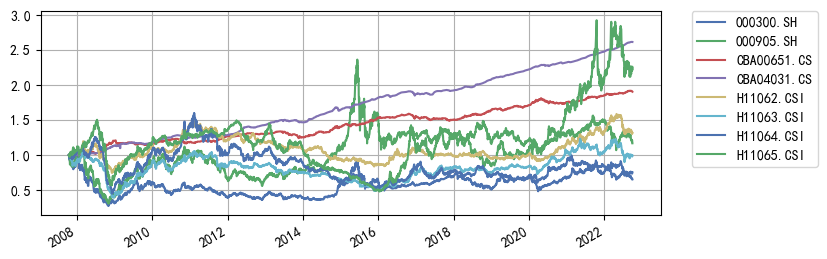

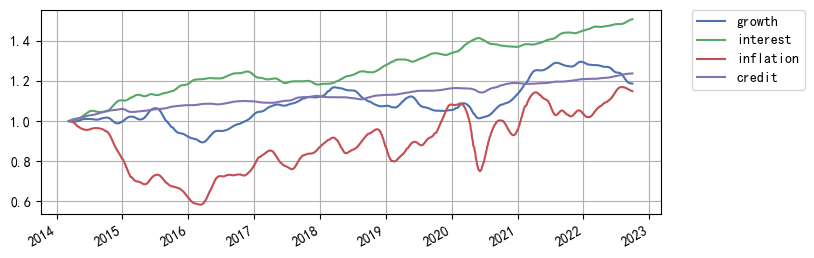

In [4]:
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

(factor_data.dropna()/factor_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [5]:
id_date = datetime(2019, 3, 31)
look_back = 252*3

tmp_asset_data = asset_data.loc[:id_date].iloc[-look_back:]
tmp_factor_data = factor_data.loc[:id_date].iloc[-look_back:]

asset_returns = tmp_asset_data.pct_change().fillna(0)
factor_returns = tmp_factor_data.pct_change().fillna(0)



### Step 2： Estimating Asset Class Factor Exposures

In [6]:
exposure = getFatorExposureFrame(asset_returns, factor_returns)
exposure

,growth,interest,inflation,credit
000300.SH,0.930664,-0.659634,-0.696464,0.862968
000905.SH,1.637431,0.237341,-0.132209,0.918660
CBA00651.CS,-0.319662,1.432393,-1.463571,-1.538925
CBA04031.CS,-1.370486,1.391461,-0.877398,0.072313
H11062.CSI,0.027646,-0.884551,1.414748,-0.927145
H11063.CSI,-0.183142,-0.635063,0.042614,-0.044895
H11064.CSI,-1.128361,-1.128719,0.614984,-0.661533
H11065.CSI,0.405910,0.246772,1.097296,1.318556


### Step 3: Constructing Factor-Mimicking Portfolios

In [7]:
fmp = getFactorMimickingPortfolio(asset_returns, factor_returns)
fmp

,growth,interest,inflation,credit,intercept
000300.SH,0.016832,-0.491949,-0.432001,0.156240,0.316245
000905.SH,0.173090,0.327630,0.248606,0.022032,-0.006310
CBA00651.CS,0.214961,0.084291,-0.236086,-0.392637,-0.004782
CBA04031.CS,-0.370319,0.182782,0.138286,0.333731,0.339121
H11062.CSI,0.053245,-0.024350,0.355496,-0.091179,0.431215
H11063.CSI,0.054993,-0.037030,-0.052589,0.071128,0.091424
H11064.CSI,-0.214221,-0.136545,-0.064120,-0.134422,-0.164131
H11065.CSI,0.071421,0.095170,0.042408,0.035107,-0.002783


In [8]:
# fmp回测表现
class FmpStrategy(Strategy):
    def __init__(self, factor_data=None, factor_name=None, scale=1):
        super().__init__()
        self._factor_data = factor_data
        self._factor_name = factor_name
        self._scale = scale

    def run(self, id_date, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        tmp_asset_returns = asset_data.pct_change().fillna(0)
        tmp_factor_data = self._factor_data.reindex(asset_data.index)
        tmp_factor_returns = tmp_factor_data.pct_change().fillna(0)

        return getFactorMimickingPortfolio(tmp_asset_returns, tmp_factor_returns, scale=self._scale)[self._factor_name]
      

In [9]:
fmp_value = pd.DataFrame()
fmp_weights = {}

for factor in ['intercept']+list(factor_data.columns):
    fmp_backtest = BacktestManager(
        FmpStrategy(factor_data=factor_data, factor_name=factor, scale=None), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = 22, 
        look_back = 252*3, 
    )
    fmp_backtest.run()
    fmp_value[factor] = fmp_backtest.getHistoricalValue()
    weights_dict = fmp_backtest._historcial_weights
    fmp_weights[factor] = pd.DataFrame(columns=asset_data.columns)
    for id_date, weights in weights_dict.items():
        fmp_weights[factor].loc[id_date] = weights.reindex(fmp_weights[factor].columns)



100%|██████████| 973/973 [00:05<00:00, 176.04it/s]


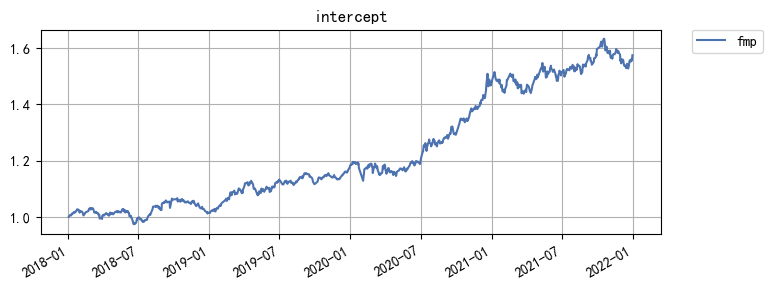

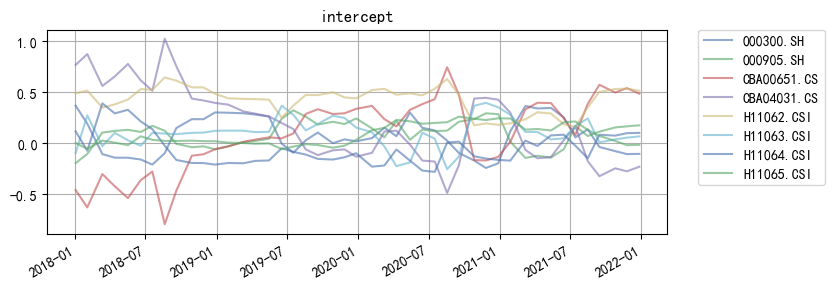

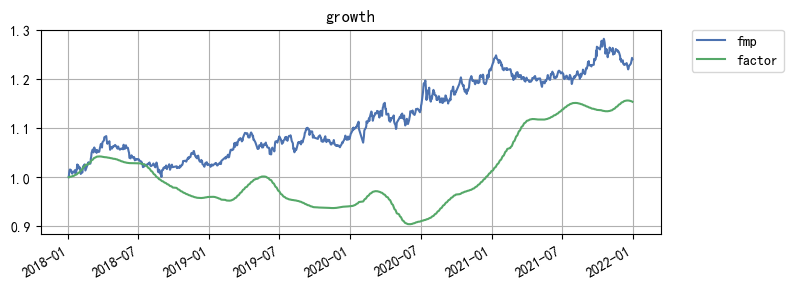

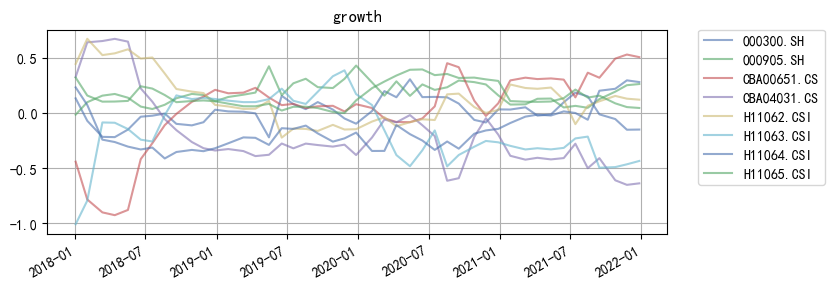

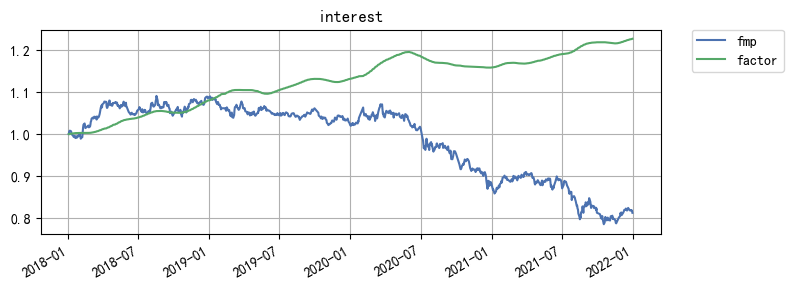

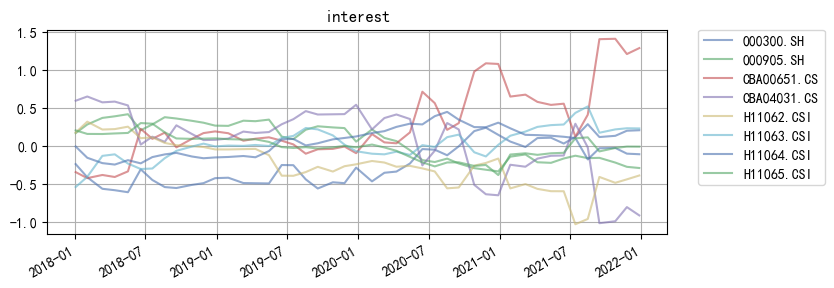

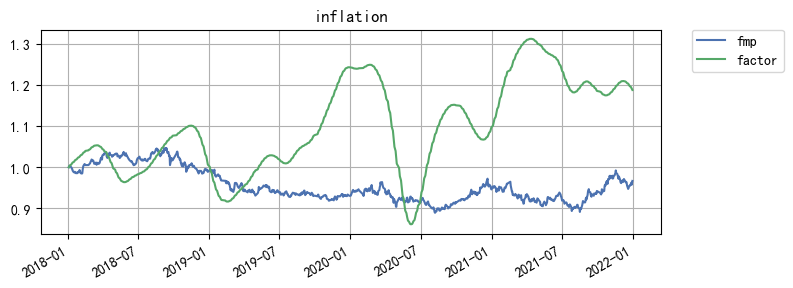

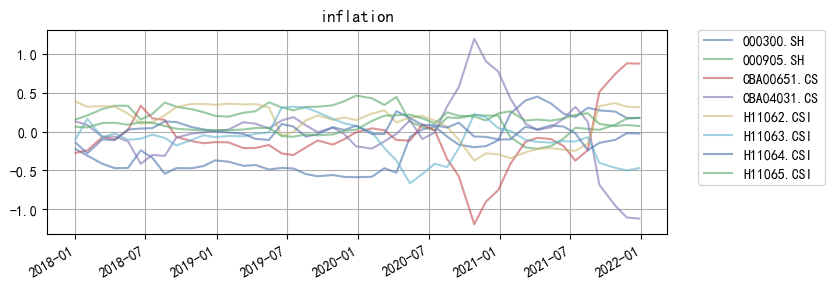

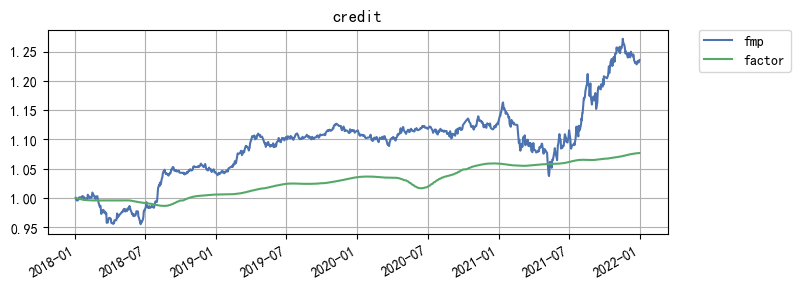

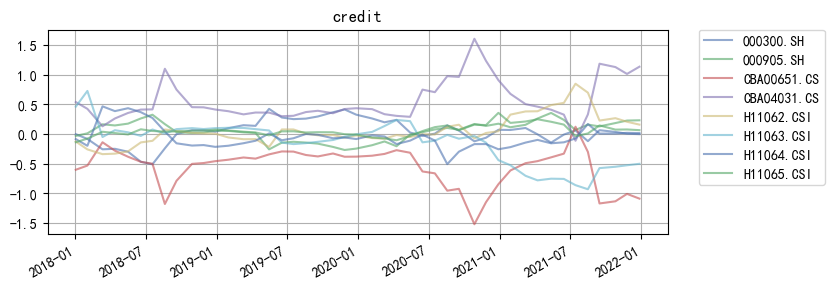

In [10]:
tmp_factor_data = factor_data.reindex(fmp_value.index)
tmp_factor_data /= tmp_factor_data.iloc[0]
fmp_value /= fmp_value.iloc[0]

for factor in ['intercept']+list(factor_data.columns):
    df = pd.DataFrame()
    df['fmp'] = fmp_value[factor]
    if factor != 'intercept':
        df['factor'] = tmp_factor_data[factor]
    df.plot(figsize=(8,3), grid=True, title=factor)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

    fmp_weights[factor].plot(figsize=(8,3), grid=True, title=factor, alpha=0.6)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)



### Step 4: Forecasting Factor-Mimicking Portfolio Return

In [11]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
tmp_fmp_returns = fmp_value.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)


### Step 5: Constructing the Optimal Factor Portfolio

In [12]:
opt_fmp_weights = optimalFactorPortfolio(tmp_fmp_returns)
opt_fmp_weights

,intercept,growth,interest,inflation,credit
0,12.396462,-19.617064,-0.393688,-7.460081,16.074371


### Step 6: Inferring Expected Returns for Asset Classes

In [13]:
tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-252:]
alpha = getAssetExpectedReturns(opt_fmp_weights, fmp, tmp_asset_returns)
alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
0,0.383504,0.191363,0.000871,0.000642,0.160789,0.15026,0.122405,0.105716


In [14]:
class AssetAlphaStrategy(Strategy):
    def __init__(self, fmp_value):
        super().__init__()
        self._asset_alpha = pd.DataFrame(columns=list(asset_data.columns))
        self._opt_fp_df = pd.DataFrame(columns=list(fmp_value))
        self._fmp_returns = fmp_value.pct_change()

    def run(self, id_date, asset_data):
        opt_fp = optimalFactorPortfolio(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        self._opt_fp_df.loc[id_date] = list(opt_fp.values[0])
        tmp_fmp_weights = pd.DataFrame({factor: v.loc[id_date].reindex(list(asset_data.columns)) for factor,v in fmp_weights.items()})
        tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-fmp_lookback:]
        self._asset_alpha.loc[id_date] = list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0])
        return pd.Series([0]*asset_data.shape[1], index=asset_data.columns)
        

In [15]:
date_range = [datetime(2019,1,31), datetime(2021,12,31)]
aa_backtest = BacktestManager(
    AssetAlphaStrategy(fmp_value), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
aa_backtest.run()

100%|██████████| 709/709 [00:03<00:00, 178.74it/s]


## 2. 复现结果

In [16]:
# fmp
fmp_value

,intercept,growth,interest,inflation,credit
2018-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-03,1.002958,1.009006,1.005175,1.002393,0.997356
2018-01-04,1.004373,1.013756,1.007768,1.003307,0.996324
2018-01-05,1.006252,1.015739,1.008062,1.003534,0.995488
2018-01-08,1.005096,1.014439,1.006649,1.000110,0.996061
...,...,...,...,...,...
2021-12-27,1.552028,1.232254,0.817779,0.959169,1.234028
2021-12-28,1.560201,1.235672,0.816742,0.962169,1.233186
2021-12-29,1.554294,1.239508,0.818108,0.957061,1.231293
2021-12-30,1.560797,1.244008,0.816049,0.962449,1.234539


In [17]:
# asset alpha
aa_backtest._strategy._asset_alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2019-01-31,0.516860,0.395540,0.031007,0.005472,-0.402797,0.134981,-0.147239,0.153785
2019-03-11,0.657412,0.736160,0.025849,0.006981,-0.319409,0.185122,-0.147450,0.178985
2019-04-11,0.484978,0.412905,0.023521,0.008252,-0.253991,0.100310,-0.055247,0.065792
2019-05-16,-0.121578,-0.937607,0.038574,0.003786,-0.455959,-0.140177,0.033255,-0.170374
2019-06-18,-1.363249,-1.607843,0.090612,0.013529,-0.014284,-0.354246,-0.078508,-0.373530
2019-07-18,-1.429661,-1.609621,0.102602,0.013621,-0.047176,-0.196695,0.063453,-0.271546
2019-08-19,-0.838786,-0.892334,0.072332,0.009583,-0.058853,-0.076265,-0.025408,-0.213608
2019-09-19,-1.144516,-0.923952,0.086413,0.012780,-0.013766,-0.068479,-0.049212,-0.245959
2019-10-28,-0.693442,-0.532685,0.066104,0.008819,-0.022993,-0.035919,0.099492,-0.140341
2019-11-27,-0.956740,-1.203544,0.073350,0.008023,0.061968,-0.261768,0.147210,-0.256502


In [19]:
aa_backtest._strategy._asset_alpha.to_csv(os.path.join(this_path, '../data/assets/asset_alpha.csv'))